# Comparison of allele frequency shifts between indoor and outdoor mesocosm
An important note on time points - 'expansion' occured in the indoor and outdoor cages between time points 1 and 11, while outdoor collapse/truncation occured between time point 11 and 12

##All data are located in the corresponding dryad repository for this manuscript: 
###https://doi.org/10.5061/dryad.hx3ffbgt1
##The key data files to download for this set of analyses is: 

1.Experiment2_IndoorOutdoorMesocosmStudy.RData: contains all allele frequency data from paired indoor/outdoor mesocosm

2.df.sig.OutdoorMesocosmExpansion.csv: contains sites identified as under (linked) selection in the paired outdoor mesocosm study and previously reported by Bitter et al. (2024) 



In [1]:
##Packages to load 
library(data.table)
library(tidyverse)
library(doMC)
library(zoo)
#Sourcing pre-written functions that are called upon in the code chunks, below
source('./general_cage_functions.R')
source("./indoor.cage.functions.R")


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   0.3.5
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.4     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()
Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: iterators

Loading required package: parallel


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




# GLM to get sites under (linked) selection during indoor cage expansion

In [11]:
##First, isolate indoor ('I' cage) allele frequency data:
##get indoor-cage specific R Data for glm
load('./Experiment2_IndoorOutdoorMesocosmStudy.RData')

df = cbind(samps, t(afmat))
df = df %>% filter(treatment == 'I' & tpt %in% c('1', '2', '8', '11' ))
#isolate read depth/effective coverage
df.eec = cbind(samps, t(eec))
df.eec = df.eec %>% filter(treatment == 'I' & tpt %in% c('1', '2', '8', '11'))

samps = df[,c(1:ncol(samps))]

afmat = df[,-c(1:ncol(samps))]
afmat = as.data.frame(t(afmat))
eec = df.eec[,-c(1:ncol(samps))]
eec = as.data.frame(t(eec))

save(samps, sites, afmat, eec, file = './orch2021_ICage.RData')

In [ ]:
##Run glm across all indoor expansion time points 
##uses fit_GLM_ContinuousTime function, which has been sourced, above
##also note that this code was run using increased computational resources: 8 cpu's and 400Gb memory (ran for ~4 hours)

load('./orch2021_ICage.RData')

comps = cbind(c('1', '2', '8', NA),c('1', '2', '8', '11'))

df.glm = sites
for (i in 1:ncol(comps)){
    load('../RData/orch2021_ICage.RData')
    vec = as.character(as.vector(na.omit(comps[,i])))
    df = cbind(samps, t(afmat))
    df = df %>% filter(tpt %in% vec)
    df.eec = cbind(samps, t(eec))
    df.eec = df.eec %>% filter(tpt %in% vec)
    samps = df[,c(1:ncol(samps))]
    afmat = df[,-c(1:ncol(samps))]
    afmat = as.data.frame(t(afmat))
    eec = df.eec[,-c(1:ncol(samps))]
    eec =  as.data.frame(t(eec))
    samps = samps %>% mutate(tpt = as.numeric(tpt))
    res = fit_GLM_ContinuousTime(afMatrix = afmat, rdMatrix = eec, sampleData = samps, vec = vec, model.vars = 'tpt',
                                ncores = 16)
    df.glm = cbind(df.glm, res)

}
save(df.glm, file = 'glm.orch2021.ICages.RData')



In [2]:
##identify significant sites from glm:
df.sig.I = get.sig.sites('./glm.orch2021.ICages.RData', rdata = './orch2021_ICage.RData',
                        comps = c('1_8', '1_11'), fdrThreshs = c(0.2, 0.05, 0.01), esThreshs = c(0.005, 0.02, 0.02))
df.sig.I = df.sig.I %>% mutate(snp = paste0(chrom, pos))
write.csv(df.sig.I,'./df.sig.I.csv', row.names = FALSE )

In [ ]:
##Get set of matched control snps for match sig level >1 sites for t1_11 comparison : 
##this was also run on a cluster with resources: 8 cpu's and 400Gb memory (ran for ~24 hours)
test.snps = read.csv('./df.sig.I.csv')
test.snps = test.snps %>% filter(comparison == '1_11' & sigLevel > 2)
load('./orch2021_Baseline_Downsampled_Filtered_Mean.RData')
base.data = cbind(sites.base, afmat.base.mean, inv.recomb)
base.data = base.data %>% mutate(Inv.Status = case_when(
                                CHROM == 'X' ~ 'outside',
                                INVDIST == 0 ~ 'inside',
                                INVDIST != 0 ~ 'outside')) %>%
    dplyr::select(-chrom, -pos) %>% mutate(SNP = paste0(CHROM, POS))
base.data = base.data %>% rename(chrom = CHROM, pos = POS, snp = SNP)


test.snps = test.snps %>% mutate(snp = paste0(chrom, pos))
snps.c = test.snps$snp
df = left_join(test.snps, base.data)
snps.c = test.snps$snp #all identified SNPS - to remove when selecting matched snps




get.matchedSNP = function (x, snps.c, base.data)
{
    chr = as.character(x$chrom)
    p = x$pos
    min.freq = x$af.base.mean - 0.025
    max.freq = x$af.base.mean + 0.025
    min.recomb = x$RECOM - 0.5
    max.recomb = x$RECOM + 0.5
    inv.stat = as.character(x$Inv.Status)
    p.matched = base.data %>% filter(chrom == chr & pos != p & between(af.base.mean, min.freq, max.freq)) %>%
        filter(between(RECOM, min.recomb, max.recomb) & Inv.Status == inv.stat) %>% filter(pos >
        p + 10000 | pos < p - 10000) %>% filter(!snp %in% snps.c) %>%
        sample_n(1) %>% rename(pos.matched = pos)
    d.new = cbind(x, p.matched %>% dplyr::select(pos.matched))
    return(d.new)
}
##Iterate through each snp w/in each cluster and get matched snps
mc.cores <- 5  # Set the number of cores you want to use here
result_list <- mclapply(1:nrow(df), function(i) get.matchedSNP(df[i, ], snps.c, base.data), mc.cores = mc.cores)
result_df <- do.call(rbind, result_list)

#save new data frame
write.csv(result_df,'./df.sig.Matched.I.1_11.csv' , row.names = FALSE)


# Are indoor cage sites enriched in outdoor cage mescosm?

In [4]:
#now, compare the overlap in significant snps identified above, with those identified during population expansion in an adjacent outdoor mesocosm
#the outdoor mesocosm sites (available on this study's dryad) were originally identified by Bitter et al. 2024; doi:10.1038/s41586-024-07834-x

df.sig.I = read.csv('./df.sig.Matched.I.1_11.csv')
df.sig.E = read.csv('./df.sig.OutdoorMesocosmExpansion.csv')
df.sig.E = df.sig.E %>% filter(sigLevel > 1) %>% mutate(snp = paste0(chrom, pos))
load("./Experiment2_IndoorOutdoorMesocosmStudy.RData")


##First, get probability of overlap using a hypergeometric test

d.stats = data.frame()
for (chr in as.character(unique(df.sig.I$chrom))){
    df.sig.i.c = df.sig.I %>% filter(chrom == chr)
    df.sig.e.c = df.sig.E %>% filter(chrom == chr)
    pval = hyperg.p(df.sig.i.c$snp, df.sig.e.c$snp, nrow(sites %>% filter(chrom == chr)))
    n.indoor = length(df.sig.i.c$snp)
    overlap.indoor = length(intersect(df.sig.i.c$snp,  df.sig.e.c$snp))
    perc.overlap.indoor = overlap.indoor/n.indoor
    d = cbind(chr,n.indoor, overlap.indoor, perc.overlap.indoor, pval)
    d.stats = rbind(d.stats, d)
    
}
#genome-wide enrichment
pval = hyperg.p(df.sig.I$snp, df.sig.E$snp, nrow(sites))
n.indoor = length(df.sig.I$snp)
overlap.indoor = length(intersect(df.sig.I$snp,  df.sig.E$snp))
perc.overlap.indoor = overlap.indoor/n.indoor
chr = 'Genome'
d.genome = cbind(chr,n.indoor, overlap.indoor, perc.overlap.indoor, pval)

#bind dataframes:
d.stats = rbind(d.stats, d.genome)
d.stats$Type = 'Target'
d.stats



chr,n.indoor,overlap.indoor,perc.overlap.indoor,pval,Type
<fct>,<fct>,<fct>,<fct>,<fct>,<chr>
2L,9879,6735,0.681749164895232,0,Target
2R,5568,3344,0.600574712643678,0,Target
3L,8442,5475,0.648542999289268,0,Target
3R,13108,9827,0.749694842844065,0,Target
X,2724,1876,0.688693098384728,0,Target
Genome,39721,27257,0.686211323984794,0,Target


In [5]:
##Now, get overlap expected empirically - i.e., using set of matched control SNPs
##Get overlap percentage for matched controls:
df.sig.matched = df.sig.I %>% dplyr::select(-pos, -snp) %>% mutate(snp = paste0(chrom, pos.matched))
d.stats.matched = data.frame()
for (chr in as.character(unique(df.sig.matched$chrom))){
    df.sig.i.c = df.sig.matched %>% filter(chrom == chr)
    df.sig.e.c = df.sig.E %>% filter(chrom == chr)
    pval = hyperg.p(df.sig.matched$snp, df.sig.e.c$snp, nrow(sites %>% filter(chrom == chr)))
    n.indoor = length(df.sig.i.c$snp)
    overlap.indoor = length(intersect(df.sig.matched$snp,  df.sig.e.c$snp))
    perc.overlap.indoor = overlap.indoor/n.indoor
    d = cbind(chr,n.indoor, overlap.indoor, perc.overlap.indoor, pval)
    d.stats.matched = rbind(d.stats.matched, d)
    
}

#genome-wide enrichment
pval = hyperg.p(df.sig.matched$snp, df.sig.E$snp, nrow(sites))
n.indoor = length(df.sig.matched$snp)
overlap.indoor = length(intersect(df.sig.matched$snp,  df.sig.E$snp))
perc.overlap.indoor = overlap.indoor/n.indoor
chr = 'Genome'
d.genome = cbind(chr,n.indoor, overlap.indoor, perc.overlap.indoor, pval)

#bind dataframes:
d.stats.matched = rbind(d.stats.matched, d.genome)
d.stats.matched$Type = 'Matched'

d.stats.meta = rbind(d.stats, d.stats.matched)
d.stats.meta = d.stats.meta %>% mutate(perc.overlap.indoor = as.numeric(as.character(perc.overlap.indoor)),
                                      n.indoor = as.numeric(as.character(n.indoor)))
d.stats.meta = d.stats.meta %>% rename(Count = n.indoor, SNPs = Type) %>%
    mutate(if_else(SNPs == 'Matched', 'Matched Controls', SNPs))
d.stats.meta = d.stats.meta %>% mutate(SNPs = if_else(SNPs == 'Matched', 'Matched Controls', 'Indoor Identified'))

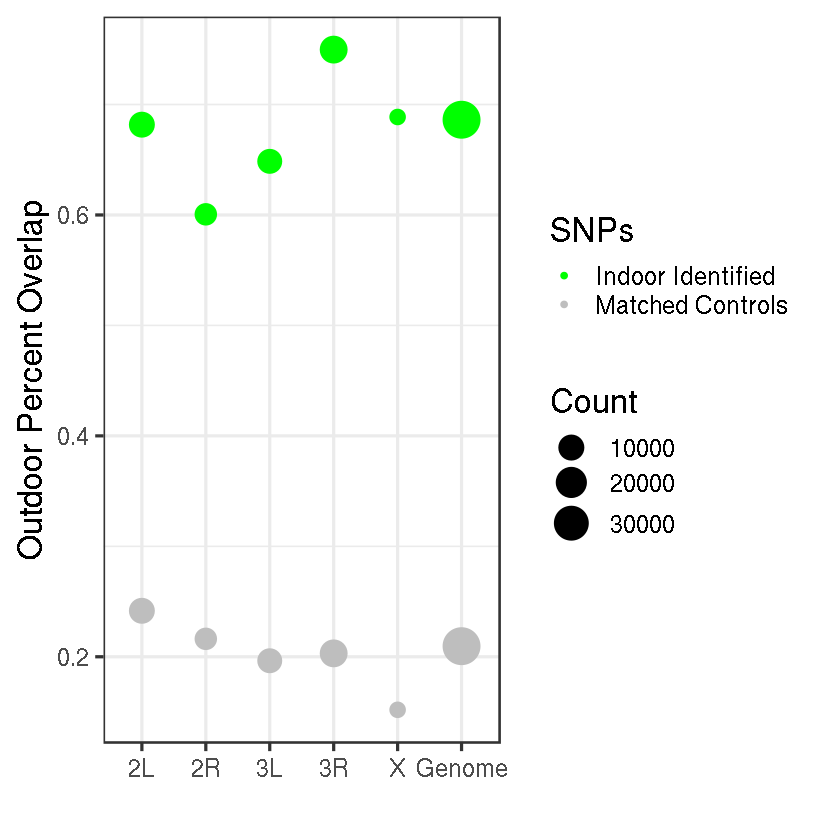

In [27]:
##FIGURE 5A

p = ggplot(d.stats.meta, aes(x = chr, y = perc.overlap.indoor, colour = SNPs, size = Count)) + 
        geom_point() +
    scale_colour_manual(values = c('green','grey')) +
    scale_size_continuous(range = c(4, 10)) + 
    ylab('Outdoor Percent Overlap') +
    xlab('') +
    theme_bw(base_size = 35) 
p
ggsave('../Figures/Indoor.Outdoor2021.SNPOverlap.pdf',p, width = 10, height = 10)

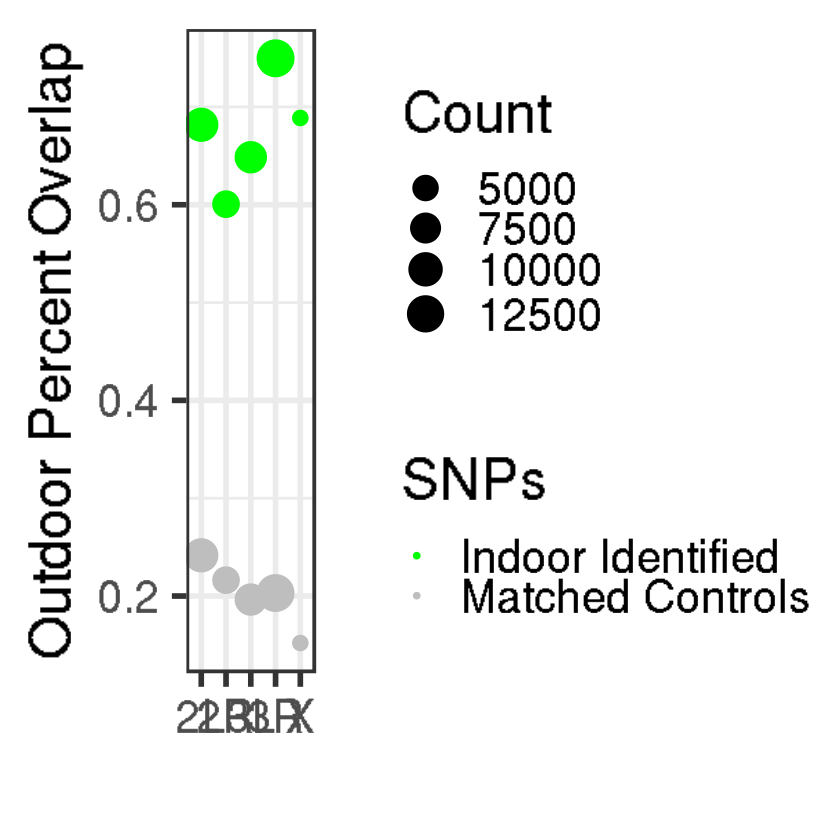

In [8]:

p.chr = ggplot(d.stats.meta %>% filter(chr != 'Genome'), aes(x = chr, y = perc.overlap.indoor, colour = SNPs, size = Count)) + 
        geom_point() +
    scale_colour_manual(values = c('green','grey')) +
    scale_size_continuous(range = c(4, 10)) + 
    ylab('Outdoor Percent Overlap') +
    xlab('') +
    theme_bw(base_size = 35) 
p.chr
ggsave('../Figures/Indoor.Outdoor2021.SNPOverlap.ByChrom.pdf',p.chr, width = 12, height = 12)

# Quantify direction and magnitude of change in indoor sites during outdoor mescosom expansion + truncation 

In [12]:
##load in .RData and then isolate allele frequencies from outdoor mesocosm
load('./Experiment2_IndoorOutdoorMesocosmStudy.RData')

df = cbind(samps, t(afmat))
df = df %>% filter(treatment == 'E' & tpt %in% c('1', '2', '8', '11', '12'))
#isolate read depth/effective coverage
df.eec = cbind(samps, t(eec))
df.eec = df.eec %>% filter(treatment == 'E' & tpt %in% c('1', '2', '8', '11', '12'))

samps = df[,c(1:ncol(samps))]

afmat = df[,-c(1:ncol(samps))]
afmat = as.data.frame(t(afmat))
eec = df.eec[,-c(1:ncol(samps))]
eec = as.data.frame(t(eec))

save(samps, sites, afmat, eec, file = './orch2021_ECage.RData')

In [13]:
e.shifts = get_af_shifts(afmat = afmat, samps = samps, comparisons = c( '1_11','11_12'))
e.shifts = cbind(sites, e.shifts)

In [14]:
df.sig.I = read.csv('./df.sig.Matched.I.1_11.csv')
df.sig.I = df.sig.I %>% mutate(sign.shift = sign(afShift))
df.sig.I.matched = df.sig.I %>% dplyr::select(-pos) %>% rename(pos = pos.matched)

In [15]:
df.shifts.target = left_join(df.sig.I, e.shifts)
df.shifts.matched = left_join(df.sig.I.matched, e.shifts)

df.shifts.target = df.shifts.target %>% dplyr::select(chrom, pos,FDR, afShift, sign.shift, dAF.1_11, dAF.11_12)
df.shifts.matched = df.shifts.matched %>% dplyr::select(chrom, pos,FDR,afShift, sign.shift, dAF.1_11, dAF.11_12)

#phase target shifts:
df.shifts.target = df.shifts.target %>% mutate(dAF.1_11 = dAF.1_11 * sign.shift,
                                dAF.11_12 = dAF.11_12 * sign.shift,)

df.shifts.target = df.shifts.target %>% gather(contains('dAF'), key = comparison, value = shift)
df.shifts.matched = df.shifts.matched %>% gather(contains('dAF'), key = comparison, value = shift)
df.shifts.target$Type = 'target'
df.shifts.matched$Type = 'matched'

Joining with `by = join_by(chrom, pos)`
Joining with `by = join_by(chrom, pos)`


In [16]:
df.shifts = rbind(df.shifts.target, df.shifts.matched)

In [18]:
#stats/shifts by chromosome
d.stats.meta = data.frame()
for (comp in c('1_11', '11_12')){
    for (chr in as.character(unique(df.shifts.target$chrom))){
        df.sub = df.shifts %>% filter(comparison == paste0('dAF.', comp) & chrom == chr)
        median.target = median((df.sub %>% filter(Type == 'target'))$shift)
        mean.target = mean((df.sub %>% filter(Type == 'target'))$shift)
        sd.target = sd((df.sub %>% filter(Type == 'target'))$shift)
        median.matched = median((df.sub %>% filter(Type == 'matched'))$shift)
        mean.matched = mean((df.sub %>% filter(Type == 'matched'))$shift)
        sd.matched = sd((df.sub %>% filter(Type == 'matched'))$shift)
        sign.test.p = (SIGN.test((df.sub %>% filter(Type == 'target'))$shift, (df.sub %>% filter(Type == 'matched'))$shift))$p.value
        t.test.pval = t.test((df.sub %>% filter(Type == 'target'))$shift, (df.sub %>% filter(Type == 'matched'))$shift)$p.value
        t.test.stat = t.test((df.sub %>% filter(Type == 'target'))$shift, (df.sub %>% filter(Type == 'matched'))$shift)$statistic
        d = cbind(comp, chr, mean.target, median.target, sd.target, mean.matched, median.matched,sd.matched, sign.test.p, t.test.pval, t.test.stat)
        d.stats.meta = rbind(d.stats.meta, d)
    }

    }

In [19]:
#stats/shifts by chromosome
d.stats.meta = data.frame()
for (comp in c( '1_11', '11_12')){
    for (chr in as.character(unique(df.shifts.target$chrom))){
        df.sub = df.shifts %>% filter(comparison == paste0('dAF.', comp) & chrom == chr)
        median.target = median((df.sub %>% filter(Type == 'target'))$shift)
        mean.target = mean((df.sub %>% filter(Type == 'target'))$shift)
        median.matched = median((df.sub %>% filter(Type == 'matched'))$shift)
        mean.matched = mean((df.sub %>% filter(Type == 'matched'))$shift)
        sign.test.p = (SIGN.test((df.sub %>% filter(Type == 'target'))$shift, (df.sub %>% filter(Type == 'matched'))$shift))$p.value
        t.test.pval = t.test((df.sub %>% filter(Type == 'target'))$shift, (df.sub %>% filter(Type == 'matched'))$shift)$p.value
        t.test.stat = t.test((df.sub %>% filter(Type == 'target'))$shift, (df.sub %>% filter(Type == 'matched'))$shift)$statistic
        d = cbind(comp, chr, mean.target, median.target, mean.matched, median.matched,sign.test.p, t.test.pval, t.test.stat)
        d.stats.meta = rbind(d.stats.meta, d)
    }

    }
d.stats.meta = d.stats.meta %>% mutate(sign.test.p = as.numeric(as.character(sign.test.p)),
                                    t.test.pval = as.numeric(as.character(t.test.pval)),
                                      median.target = as.numeric(as.character(median.target)),
                                      median.matched = as.numeric(as.character(median.matched))) 
d.stats.meta = d.stats.meta %>% mutate(FDR.t.test = p.adjust(t.test.pval, method = 'BH'),
                                      FDR.sign.test = p.adjust(sign.test.p, method = 'BH'))

d.stats.meta =d.stats.meta %>%  mutate(significant = if_else(FDR.t.test < 0.05, 'yes', 'no'))
d.stats.meta = d.stats.meta %>% gather(median.target, median.matched, key = type, value = median)

d.stats.meta = d.stats.meta %>%
    mutate(colour = case_when(type == 'median.target' & significant == 'yes' & median > 0 ~ 'purple',
                      type == 'median.target' & significant == 'yes' & median < 0 ~ 'orange',
                      type == 'median.target' & significant == 'no'  ~ 'dark grey' ,       
                     type == 'median.matched' ~ 'black'))

In [21]:
#stats/shift - whole genome
d.stats.meta.genome = data.frame()
for (comp in c('1_11', '11_12')){
        df.sub = df.shifts %>% filter(comparison == paste0('dAF.', comp))
        median.target = median((df.sub %>% filter(Type == 'target'))$shift)
        mean.target = mean((df.sub %>% filter(Type == 'target'))$shift)
        median.matched = median((df.sub %>% filter(Type == 'matched'))$shift)
        mean.matched = mean((df.sub %>% filter(Type == 'matched'))$shift)
        sign.test.p = (SIGN.test((df.sub %>% filter(Type == 'target'))$shift, (df.sub %>% filter(Type == 'matched'))$shift))$p.value
        t.test.pval = t.test((df.sub %>% filter(Type == 'target'))$shift, (df.sub %>% filter(Type == 'matched'))$shift)$p.value
        t.test.stat = t.test((df.sub %>% filter(Type == 'target'))$shift, (df.sub %>% filter(Type == 'matched'))$shift)$statistic
        d = cbind(comp, chr, mean.target, median.target, mean.matched, median.matched,sign.test.p, t.test.pval, t.test.stat)
        d.stats.meta.genome = rbind(d.stats.meta.genome, d)
    }

d.stats.meta.genome$chr = 'Genome'  
d.stats.meta.genome = d.stats.meta.genome %>% mutate(sign.test.p = as.numeric(as.character(sign.test.p)),
                                    t.test.pval = as.numeric(as.character(t.test.pval)),
                                      median.target = as.numeric(as.character(median.target)),
                                      median.matched = as.numeric(as.character(median.matched))) 
d.stats.meta.genome = d.stats.meta.genome %>% mutate(FDR.t.test = p.adjust(t.test.pval, method = 'BH'),
                                      FDR.sign.test = p.adjust(sign.test.p, method = 'BH'))

d.stats.meta.genome =d.stats.meta.genome %>%  mutate(significant = if_else(FDR.t.test < 0.05, 'yes', 'no'))
d.stats.meta.genome = d.stats.meta.genome %>% gather(median.target, median.matched, key = type, value = median)

d.stats.meta.genome = d.stats.meta.genome %>%
    mutate(colour = case_when(type == 'median.target' & significant == 'yes' & median > 0 ~ 'purple',
                      type == 'median.target' & significant == 'yes' & median < 0 ~ 'orange',
                      type == 'median.target' & significant == 'no'  ~ 'dark grey' ,       
                     type == 'median.matched' ~ 'black'))

In [22]:
d.stats.meta = rbind(d.stats.meta, d.stats.meta.genome)

In [23]:
stats.1_11 = d.stats.meta %>% filter(comp == '1_11') %>% dplyr::select(-colour) %>% spread(key = type, value = median) %>%
    dplyr::select(chr, mean.target, median.target, mean.matched, median.matched,t.test.stat, FDR.t.test, FDR.sign.test) %>%
    rename(Chromosome = chr, Mean.Target = mean.target, Median.Target = median.target, Mean.Matched = mean.matched,
          Median.Matched = median.matched, t =  t.test.stat)
stats.1_11$Test.Interval = 'Expansion'

In [24]:
stats.11_12 = d.stats.meta %>% filter(comp == '11_12') %>% dplyr::select(-colour) %>% spread(key = type, value = median) %>%
    dplyr::select(chr, mean.target, median.target, mean.matched, median.matched,t.test.stat, FDR.t.test, FDR.sign.test) %>%
    rename(Chromosome = chr, Mean.Target = mean.target, Median.Target = median.target, Mean.Matched = mean.matched,
          Median.Matched = median.matched, t =  t.test.stat)
stats.11_12$Test.Interval = 'Collapse'

In [25]:
rbind(stats.1_11, stats.11_12)

Chromosome,Mean.Target,Median.Target,Mean.Matched,Median.Matched,t,FDR.t.test,FDR.sign.test,Test.Interval
<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<chr>
2L,0.0319985981378007,3.038013e-02,0.00316831802589668,3.178635e-03,90.4650925090862,0.000000e+00,8.326673e-16,Expansion
2R,0.028969065444205,2.551098e-02,0.00115295987609255,1.615365e-03,66.0420368142833,0.000000e+00,8.326673e-16,Expansion
3L,0.0335003699797639,3.080976e-02,0.00286597441953921,3.928358e-03,90.8841932663739,0.000000e+00,8.326673e-16,Expansion
3R,0.0369291946950844,3.378144e-02,0.00264119051901511,3.484494e-03,129.54052005962,0.000000e+00,8.326673e-16,Expansion
X,0.0288667950506608,2.644817e-02,0.0025943771973813,3.045992e-03,60.462689719572,0.000000e+00,8.326673e-16,Expansion
Genome,0.0333054320018882,3.057965e-02,0.00260823894732216,3.234185e-03,199.627700493635,0.000000e+00,8.326673e-16,Expansion
2L,-0.00487214737932314,-4.692767e-03,-0.00104825093438945,-9.152650e-04,-19.5690789120401,2.356927e-84,7.180716e-52,Collapse
2R,0.000478905306333812,8.868033e-04,-0.000171925992292266,4.171333e-05,2.8948882077324,3.958655e-03,9.993639e-05,Collapse
3L,0.00187994456347232,1.696414e-03,-7.9971808333333e-05,2.173192e-04,8.39801534836484,5.830216e-17,1.057355e-15,Collapse


In [28]:
d.stats.meta = d.stats.meta %>% rename(SNPs = type) %>% 
    mutate(SNPs = if_else(SNPs == 'median.matched', 'Matched Controls', 'Indoor Identified'))

In [29]:
head(d.stats.meta)

,comp,chr,mean.target,mean.matched,sign.test.p,t.test.pval,t.test.stat,FDR.t.test,FDR.sign.test,significant,SNPs,median,colour
,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
1,1_8,2L,0.0148796352421804,0.000896702916405169,6.661338e-16,0,56.9062794318936,0,8.326673e-16,yes,Indoor Identified,0.01411061,purple
2,1_8,2R,0.0148461600830639,0.000343185053041187,4.440892e-16,0,47.8304146139318,0,8.326673e-16,yes,Indoor Identified,0.01306916,purple
3,1_8,3L,0.0155445701441207,0.000440416224117507,6.661338e-16,0,75.7358407939275,0,8.326673e-16,yes,Indoor Identified,0.01415439,purple
4,1_8,3R,0.0172009850174702,0.000940999858000203,6.661338e-16,0,104.181009826562,0,8.326673e-16,yes,Indoor Identified,0.01611423,purple
5,1_8,X,0.017590465868698,0.00103073786857562,2.220446e-16,0,54.2858136054305,0,8.326673e-16,yes,Indoor Identified,0.01653562,purple
6,8_12,2L,0.0122468155162972,0.00122336417510207,6.661338e-16,0,53.9161592100466,0,8.326673e-16,yes,Indoor Identified,0.01087682,purple


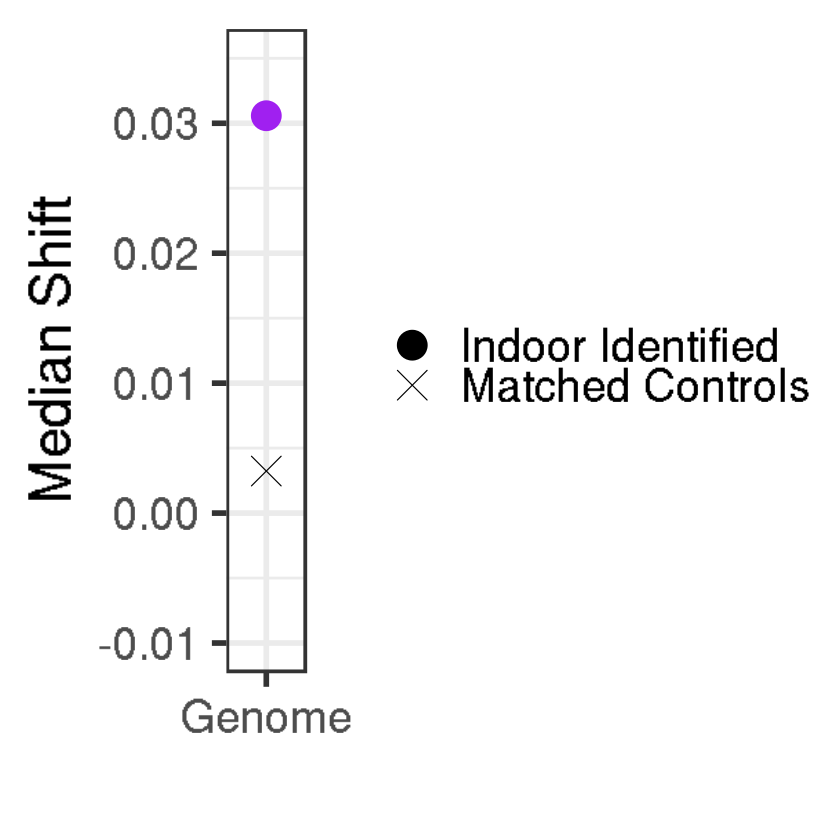

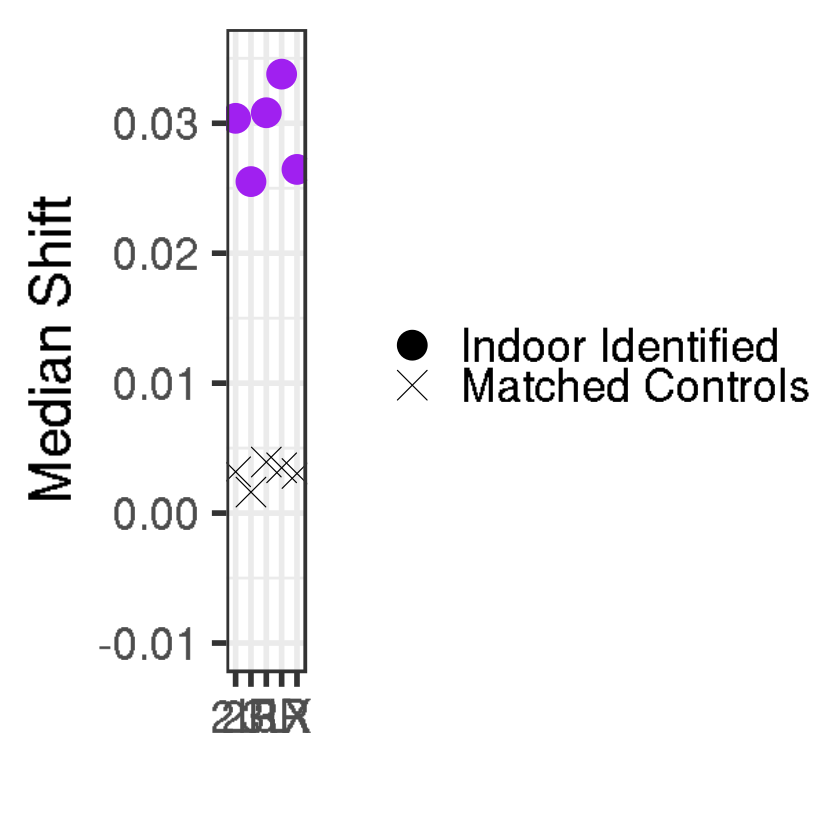

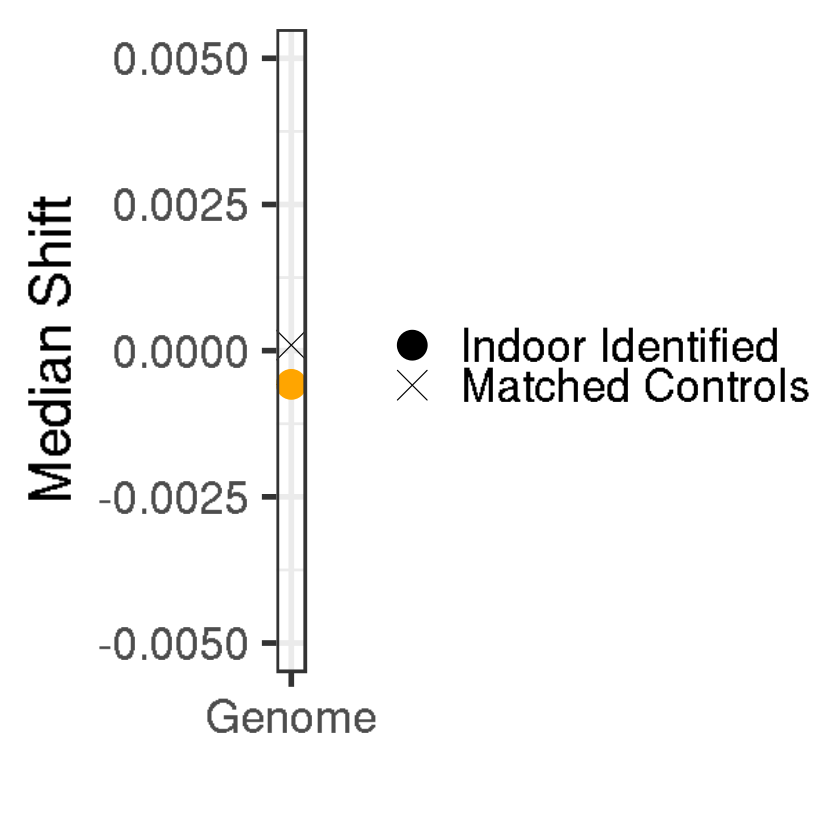

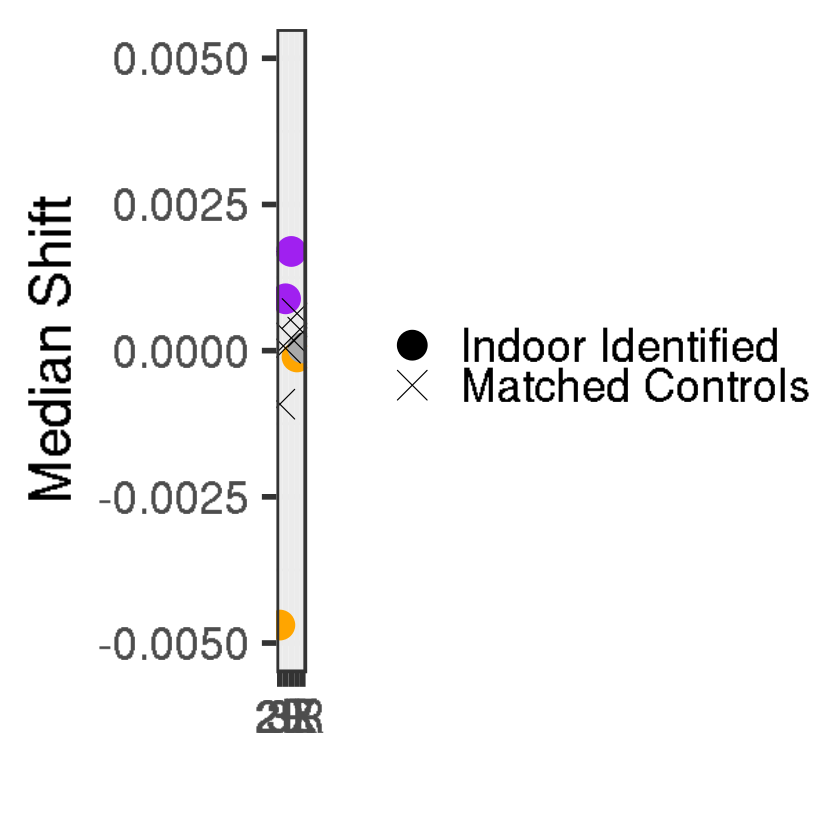

In [33]:
###FIGURE 5B+5C:


p.exp.gen = ggplot(d.stats.meta %>% filter(comp %in% c('1_11') & chr == 'Genome') %>% mutate(comp = 'Population Expansion'), aes(x = chr, y = median, colour = colour, shape = SNPs)) +
    geom_point(size = 8) +
    scale_colour_identity() + 
    #facet_wrap(~comp) +
    theme_bw(base_size = 35) +
    scale_shape_manual(values = c(19, 4)) +
    ylab('Median Shift') +
    #theme(legend.position = "none") +
      theme(legend.title=element_blank()) + 
    xlab('') +
    ylim(-0.01, 0.035)
    #scale_x_discrete(limits = c('Genome', '2L', '2R', '3L', '3R', 'X'))
p.exp.gen
ggsave('../Figures/Indoor.OutdoorTest2021.Expansion.Genome.pdf', p.exp.gen,width = 9, height = 12)

p.exp.chr = ggplot(d.stats.meta %>% filter(comp %in% c('1_11') & chr != 'Genome') %>% mutate(comp = 'Population Expansion'), aes(x = chr, y = median, colour = colour, shape = SNPs)) +
    geom_point(size = 8) +
    scale_colour_identity() + 
    #facet_wrap(~comp) +
    theme_bw(base_size = 35) +
    scale_shape_manual(values = c(19, 4)) +
    ylab('Median Shift') +
    #theme(legend.position = "none") +
      theme(legend.title=element_blank()) + 
    xlab('') +
    ylim(-0.01, 0.035)
    #scale_x_discrete(limits = c('Genome', '2L', '2R', '3L', '3R', 'X'))
p.exp.chr
ggsave('../Figures/Indoor.OutdoorTest2021.Expansion.ByChr.pdf', p.exp.chr,width = 12, height = 12)


p.trunc = ggplot(d.stats.meta %>% filter(comp %in% c('11_12') & chr == 'Genome') %>% mutate(comp = 'Population Collapse'), aes(x = chr, y = median, shape = SNPs, colour = colour)) +
    geom_point(size = 8) +
    scale_colour_identity() + 
    theme_bw(base_size = 35) +
    ylab('Median Shift') +
    theme(legend.title=element_blank()) + 
    scale_shape_manual(values = c(19, 4)) +
    #theme(legend.position = "none")  +
    xlab('') +
    ylim(-0.005, 0.005)

p.trunc
ggsave('../Figures/Indoor.OutdoorTest2021.Collapse.Genome.pdf',p.trunc, width = 9, height = 12)

p.trunc.chr = ggplot(d.stats.meta %>% filter(comp %in% c('11_12') & chr != 'Genome') %>% mutate(comp = 'Population Collapse'), aes(x = chr, y = median, shape = SNPs, colour = colour)) +
    geom_point(size = 8) +
    scale_colour_identity() + 
    theme_bw(base_size = 35) +
    ylab('Median Shift') +
    theme(legend.title=element_blank()) + 
    scale_shape_manual(values = c(19, 4)) +
    #theme(legend.position = "none")  +
    xlab('')+
    ylim(-0.005, 0.005)
p.trunc.chr
ggsave('../Figures/Indoor.OutdoorTest2021.Collapse.ByChrom.pdf',p.trunc.chr, width = 12, height = 12)
